# Senate vote position prediction using transductive learning

Predicting the positions of senators on a given bill, given its cosponsors.

## 1 Data preprocessing

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
import scipy
from scipy import sparse
import networkx as nx
from lib import graph
from pyunlocbox import functions, solvers

import warnings # For RandomForestRegressor
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline 
%load_ext autoreload
%autoreload

## 1.1 Genearting train and test data

The train data will be used to generate the adjacency matrix and train the threshold regressor.

In [2]:
def numeric_votes(vote_position):
    ''' 
    Converts vote positions to numeric values:
        Yes -> 1
        Not voting -> 0
        No -> -1
    '''
    if vote_position == 'Yes':
        return 1
    elif vote_position == 'Not Voting' or pd.isnull(vote_position):
        return 0
    else:
        return -1

def get_train_test(senate_id=115, ratio_train=0.5, ratio_val=0.1, shuffle=False, seed=123):
    '''
    Loads bills and votes and generates training, validation
    and testing data. Inputs are cosponsor vote positions and
    targets are the final vote outcomes.
    '''
    # Load votes and bills
    VOTES_PATH = '../data/votes/votes_{}.csv'.format(senate_id)
    BILLS_PATH = '../data/bills/bills_{}.csv'.format(senate_id)
    bills = pd.read_csv(BILLS_PATH)
    votes = pd.read_csv(VOTES_PATH)
    
    # Keep only the bills sponsored by Senators
    bills_sen = bills[bills.sponsor_title=='Sen.']
    N_BILLS_SEN = bills_sen.shape[0]
    
    # Get the members
    members_aux = pd.DataFrame(list(votes['member_id'].unique())).rename(columns={0: 'member_id'})
    members = members_aux.merge(votes.drop_duplicates(subset='member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
    N_SENATORS = len(members)
                   
    for i,j in enumerate(bills_sen.cosponsors_sen):
        bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)
    
    # Create binary matrices indicating sponsorship
    S = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, j in enumerate(bills_sen.cosponsors_sen):
        S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1
    
    # Create binary matrices indicating cosponsorship
    CS = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, j in enumerate(bills_sen.cosponsors_sen):
        for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
            CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1
          
    # Sponsorship mask
    Z = S + CS
    
    # The target Y is the vote position of all senators for a given bill
    Y = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, l in enumerate(list(bills_sen.vote_uri)):
        votes_i = (members.merge(votes[votes.vote_uri == l], how='left'))
        feature = votes_i.vote_position.apply(numeric_votes).values
        Y[i] = feature
    
    # The input data X is the vote position of all (co)sponsors for a given bill
    X = np.zeros((N_BILLS_SEN, N_SENATORS))
    X[Z==1] = Y[Z==1]
    
    n = X.shape[0]
    d = X.shape[1]
    
    n_train = int(n * ratio_train)
    n_val = int(n * ratio_val)

    if shuffle:
        np.random.seed(seed)
        perm_idx = np.random.permutation(n)
    else:
        perm_idx = np.arange(n)
    X_train = X[perm_idx[:n_train]]
    X_val = X[perm_idx[n_train:n_train+n_val]]
    X_test = X[perm_idx[n_train+n_val:]]

    y_train = Y[perm_idx[:n_train]]
    y_val = Y[perm_idx[n_train:n_train+n_val]]
    y_test = Y[perm_idx[n_train+n_val:]]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
data = get_train_test(senate_id=115, ratio_train=0.5, ratio_val=0, shuffle=True)
X_train, _, X_test, y_train, _, y_test = data

Below we plot one example of how the input and targets look like, with the input only containing the cosponsor positions and the truth containing all final votes.

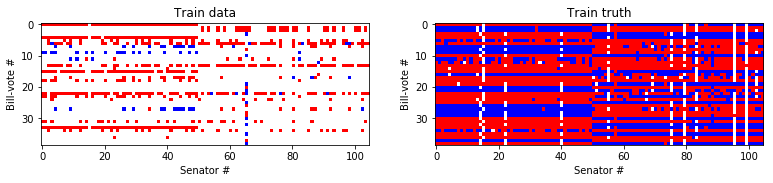

In [38]:
mycmap = ListedColormap(['blue','white','red'])

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Train data')
plt.subplot(1,3,2)
plt.imshow(y_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Train truth');

## 1.2 Computing the adjacency matrix and its gradient

Computing the adjacency matrix:

In [6]:
def compute_adjacency(y, k=15):
    '''
    Computes an adjacency matrix from 
    '''
    dist, idx = graph.distance_scipy_spatial(y.T, k=k, metric='euclidean')
    A = graph.adjacency(dist, idx).astype(np.float32)
    A = (A > 0.01).astype(np.float32)
    return A

# Create the adjacency matrix on the training positions of all senators
A = compute_adjacency(y_train)

d = |V| = 105, k|V| < |E| = 2170


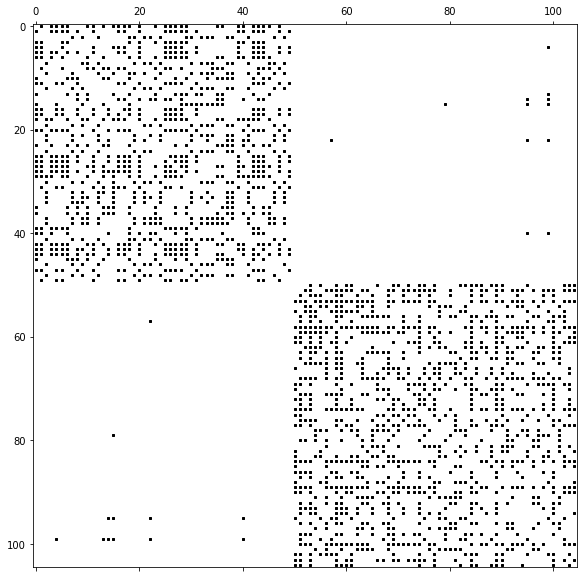

In [7]:
print('d = |V| = {}, k|V| < |E| = {}'.format(A.shape[0], A.nnz))
plt.figure(figsize=(10,10))
plt.spy(A, markersize=2, color='black');

Computing the gradient / Incident matrix:

In [10]:
def compute_incident_matrix(A):
    d = A.shape[0]
    S = np.zeros((d, int(A.sum() // 2)))
    edge_idx = 0
    for i in range(d):
        for k in range(i):
            if A[i,k] == 1.0:
                S[i,edge_idx] = 1
                S[k,edge_idx] = -1
                edge_idx += 1
    return S

S = compute_incident_matrix(A)

## 2 Transductive learning

### 2.1 Setup for Transductive Learning

Setting up the solver for the transductive learning problem:

In [11]:
def P(a, w, labels):
    '''
    Enforces that the input ground truth labels stay the
    same throughout optimization, by replacing the predicted
    values with the labels.
    '''
    mask_pos = np.where(w==1)
    b = a.copy()
    b[mask_pos] = labels[mask_pos]
    return b

def graph_pnorm_interpolation(gradient, P, w, x0=None, p=1., **kwargs):
    r'''
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    '''
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z, w, x0)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, 
                                **kwargs, verbosity='NONE')
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, 
                                **kwargs, verbosity='NONE')
        return problem['sol']
    else:
        return x0
    
def predict_votes(known_votes, S, p=1.):
    ''' Given the cosponsors votes, returns the result of the optimization. '''
    # Mask showing which entries have data
    w = (known_votes != 0).astype(int)  
    sol_min = graph_pnorm_interpolation(sparse.csr_matrix(S).T, P, w, 
                                        x0=known_votes.copy(), p=p)
    return sol_min

### 2.2 Finding optimal thresholds

Because the solutions from the transductive learning problem are not yet binarized into "Yay" and "Nay" vote predictions, we have to pick a threshold for choosing how we bin our predictions. For different outcomes, different thresholds might be optimal. If we knew the optimal threshold, we show below that we can very accurately predict the true vote outcomes, if we only know the cosponsor positions. For this reason, we would like to pick the best threshold at test time, without peaking at how the senators actually voted on a given bill! 

Our strategy of estimating this threshold consists of first building a small dataset in the following way: We iterate over all bills in the training set and generate a vote prediction for all senators from the known cosponsor positions. Knowing the true vote result, we search the threshold for binarizing our predictions that leads to the smallest relative error between prediction and ground truth. This threshold will be the target in our dataset. For features, we collect some statistics about the cosponsors, such as the number of cosponsors in each party and flags if there are or are not any cosponsors in each party.

Using this dataset, we can learn a good threshold value based on some statistics about the cosponsors. We will apply this Machine Learning model to get thresholds on test data.

Now we set up the functions allowing us to search for the best threshold:

In [12]:
def rel_err(truth, preds):
    ''' 
    Calculates the relative error between the true labels and an estimate
    
    Args:
        truth: Ground truth signal
        preds: Estimated signal
    '''
    voted_idxs = np.where(truth != 0)
    return np.linalg.norm(truth[voted_idxs] - preds[voted_idxs], 2) / np.linalg.norm(truth[voted_idxs], 2)

def compute_acc(truth, preds):
    valid_indices = np.where(np.any([truth==1, truth==-1], axis=0))
    return (truth[valid_indices] == preds[valid_indices]).sum() / len(valid_indices)

def binarize(preds, threshold):
    preds_bin = (preds > threshold).astype(int)
    preds_bin[preds_bin==0] = -1
    return preds_bin

def search_best_threshold(truth, preds):
    best_error = np.inf
    best_threshold = 0
    
    thresholds = np.linspace(-1, 1, 100000)
    for t in thresholds:
        preds_bin = binarize(preds, t)
        r_err = rel_err(truth, preds_bin)
        if r_err < best_error:
            best_threshold = t
            best_error = r_err
    return best_threshold

Building the threshold dataset over all training samples:

In [13]:
def features_from_cosponsors(known_votes):
    # Taking independent parties as democrats
    dems_yay = (known_votes[:50] == 1).sum()
    dems_nay = (known_votes[:50] == -1).sum()
    reps_yay = (known_votes[50:] == 1).sum()
    reps_nay = (known_votes[50:] == -1).sum()
    no_dem_sponsors = (dems_yay + dems_nay == 0)
    no_rep_sponsors = (reps_yay + reps_nay == 0)
    dems_maj = (dems_yay + dems_nay > reps_yay + reps_nay)
    return [dems_yay, dems_nay, reps_yay, reps_nay, no_dem_sponsors, no_rep_sponsors, dems_maj]

In [14]:
def generate_threshold_dataset(X_train, y_train, S):
    features = []
    ts = []
    errs = []
    accs = []

    for idx in range(X_train.shape[0]):
        known_votes = X_train[idx]
        true_votes = y_train[idx]

        pred_votes = predict_votes(known_votes, S, p=1.)

        t = search_best_threshold(true_votes, pred_votes)
        pred_votes_bin = binarize(pred_votes, t)
        r_err = rel_err(true_votes, pred_votes_bin)
        acc = compute_acc(true_votes, pred_votes_bin)

        features.append(features_from_cosponsors(known_votes))
        ts.append(t)
        errs.append(r_err)
        accs.append(acc)

    features = np.array(features)
    ts = np.array(ts)
    errs = np.array(errs)
    accs = np.array(accs)
    return features, ts, errs, accs

features, ts, errs, accs = generate_threshold_dataset(X_train, y_train, S)

If we always pick the optimal threshold, using this transductive learning method we can get the following mean accuracies and relative errors:

In [15]:
print('Accuracy       - Mean: {:.2f}%, Std: {:.2f}%'.format(accs.mean(), accs.std()))
print('Relative error - Mean: {:.2f}, Std: {:.2f}'.format(errs.mean(), errs.std()))

Accuracy       - Mean: 93.62%, Std: 6.37%
Relative error - Mean: 0.35, Std: 0.27


### 2.3 Predictive model for thresholds

Now that we built the threshold dataset, we want to train a Machine Learning model to predict new thresholds based on unseen inputs. We train a Random Forest Regressor from scikit-learn using standard parameters, but changed the criterion to the Mean Absolute Error. Using this loss, we get much better results than with the standard Mean Squared Error, as the latter is much more susceptible to outliers.

In [16]:
rf = RandomForestRegressor(criterion='mae')
rf.fit(features, ts)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Feature importances:

In [17]:
print(rf.feature_importances_)

[0.28514571 0.17086255 0.17586957 0.11125401 0.09204672 0.04847336
 0.11634808]


We now evaluate how well our trained Random Forest can predict thresholds and how accurate our final predictions are:

In [18]:
def evaluate_method(X_test, y_test, S):
    errs_test = []
    accs_test = []

    for idx in range(X_test.shape[0]):
        known_votes = X_test[idx]
        true_votes = y_test[idx]

        pred_votes = predict_votes(known_votes, S, p=1.)

        f = np.array(features_from_cosponsors(known_votes)).reshape(1,-1)
        t = rf.predict(f)

        pred_votes_bin = binarize(pred_votes, t)
        r_err = rel_err(true_votes, pred_votes_bin)
        acc = compute_acc(true_votes, pred_votes_bin)

        errs_test.append(r_err)
        accs_test.append(acc)

    errs_test = np.array(errs_test)
    accs_test = np.array(accs_test)
    return errs_test, accs_test

errs_test, accs_test = evaluate_method(X_test, y_test, S)

In [19]:
print('Accuracy       - Mean: {:.2f}%, Std: {:.2f}%'.format(accs_test.mean(), accs_test.std()))
print('Relative error - Mean: {:.2f}, Std: {:.2f}'.format(errs_test.mean(), errs_test.std()))

Accuracy       - Mean: 81.55%, Std: 19.08%
Relative error - Mean: 0.66, Std: 0.48


In [20]:
def predict_binarized_vote(known_votes, S, rf):
    # Do the transductive learning optimization
    pred_votes = predict_votes(known_votes, S, p=1.)
    # Generate features for the random forest
    f = np.array(features_from_cosponsors(known_votes)).reshape(1,-1)
    # Predict the threshold
    t = float(rf.predict(f))
    # Generate the binarized predictions
    pred_votes_bin = binarize(pred_votes, t)
    return pred_votes_bin, t

In [21]:
G = nx.from_numpy_matrix(A.todense())
coords = nx.spring_layout(G) # Force-directed layout.

import matplotlib.patches as mpatches

def plot_predictions(known_votes, true_votes, pred_votes, G, coords):
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=known_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[0])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[0])
    ax[0].set_title('Known cosponsor votes')
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=true_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[1])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[1])
    ax[1].set_title('Final votes')
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=pred_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[2])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[2])
    ax[2].set_title('Predicted votes')
    
    # Legend
    yes_patch = mpatches.Patch(label='Voted Yes', edgecolor='black', facecolor='red')
    no_patch  = mpatches.Patch(label='Voted No', edgecolor='black', facecolor='blue')
    not_voted_patch  = mpatches.Patch(label='Did not vote', edgecolor='black', facecolor='white')
    fig.legend(handles=[yes_patch, no_patch, not_voted_patch], loc='lower center', ncol=3)
    fig.subplots_adjust(bottom=0.12)
    
    plt.show()
    fig.savefig('../plots/transductive_example.pdf', bbox_inches='tight')

Relative error 0.40, accuracy 94.00% for threshold 0.93444


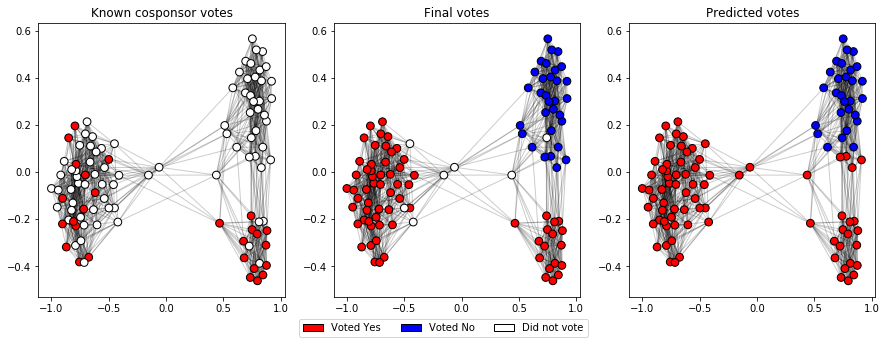

In [22]:
test_idx = 2
known_votes = X_test[test_idx]
true_votes = y_test[test_idx]

pred_votes_bin, t = predict_binarized_vote(known_votes, S, rf)

r_err = rel_err(true_votes, pred_votes_bin)
acc = compute_acc(true_votes, pred_votes_bin)

print('Relative error {:.2f}, accuracy {:.2f}% for threshold {:.5f}'.format(r_err, acc, t))
plot_predictions(known_votes, true_votes, pred_votes_bin, G, coords)

## 3 Analysis of all congresses

In [38]:
senate_ids = [105, 107, 108, 109, 110, 111, 112, 113, 114, 115]

accs_senates = {}
errs_senates = {}

for senate_id in senate_ids:
    print('Evaluating senate #{}'.format(senate_id))
    # Generate the train and test data
    data = get_train_test(senate_id=senate_id, ratio_train=0.5, ratio_val=0, shuffle=True)
    X_train, _, X_test, y_train, _, y_test = data
    # Generate the adjacency and incident matrix
    A = compute_adjacency(y_train)
    S = compute_incident_matrix(A)
    # Generate the train data for the random forest and train it
    features, ts, _, _ = generate_threshold_dataset(X_train, y_train, S)
    rf = RandomForestRegressor(criterion='mae')
    rf.fit(features, ts)
    # Evaluate the method and save accuracies and relative errors
    errs_test, accs_test = evaluate_method(X_test, y_test, S)
    accs_senates[senate_id] = accs_test
    errs_senates[senate_id] = errs_test
    
accs_senates = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in accs_senates.items() ]))
errs_senates = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in errs_senates.items() ]))

Evaluating senate #105
Evaluating senate #107
Evaluating senate #108
Evaluating senate #109
Evaluating senate #110
Evaluating senate #111
Evaluating senate #112
Evaluating senate #113
Evaluating senate #114
Evaluating senate #115


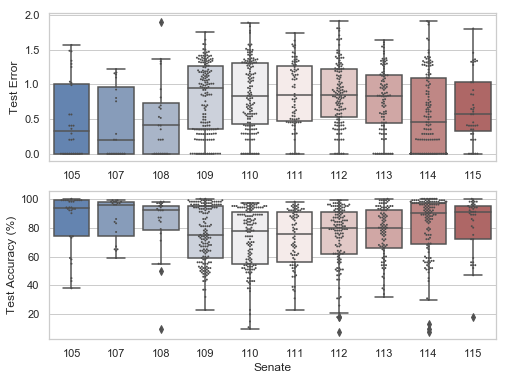

In [41]:
fig, ax= plt.subplots(2,1, figsize=(8,6))
sns.set(style="whitegrid")
sns.boxplot(data=errs_senates, palette="vlag", ax=ax[0])
sns.swarmplot(data=errs_senates, size=2, color=".3", ax=ax[0])
sns.boxplot(data=accs_senates, palette="vlag", ax=ax[1])
sns.swarmplot(data=accs_senates, size=2, color=".3", ax=ax[1])
ax[0].set_ylabel('Test Error')
ax[1].set_ylabel('Test Accuracy (%)')
plt.xlabel('Senate')
plt.savefig('../plots/test_err_transduct.pdf')